 # Lab 8:  Transfer Learning with a Pre-Trained Deep Neural Network

As we discussed earlier, state-of-the-art neural networks involve millions of parameters that are prohibitively difficult to train from scratch.  In this lab, we will illustrate a powerful technique called *fine-tuning* where we start with a large pre-trained network and then re-train only the final layers to adapt to a new task.  The method is also called *transfer learning* and can produce excellent results on very small datasets with very little computational time.  

This lab is based partially on this
[excellent blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).  In performing the lab, you will learn to:
* Build a custom image dataset
* Fine tune the final layers of an existing deep neural network for a new classification task.
* Load images with a `DataGenerator`.

You may run the lab on a CPU machine (like your laptop) or a GPU.  See the [notes](../GCP/gpu_setup.md) on setting up a GPU instance on Google Cloud Platform.  The GPU training is much faster (< 1 minute).  But, even the CPU machine training time will be less than 20 minutes.

## Create a Dataset

In this example, we will try to develop a classifier that can discriminate between two classes:  `cars` and `bicycles`.  One could imagine this type of classifier would be useful in vehicle vision systems.   The first task is to build a dataset.  

TODO:  Create training and test datasets with:
* 1000 training images of cars
* 1000 training images of bicylces
* 300 test images of cars
* 300 test images of bicylces
* The images don't need to be the same size.  But, you can reduce the resolution if you need to save disk space.

The images should be organized in the following directory structure:

    ./train
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0999.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0999.jpg
    ./test
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0299.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0299.jpg
           
The naming of the files within the directories does not matter.  The `ImageDataGenerator` class below will find the filenames.  Just make sure there are the correct number of files in each directory.
           
A nice automated way of building such a dataset if through the [FlickrAPI](flickr_images.ipynb).           
        

## Loading a Pre-Trained Deep Network

We follow the [VGG16 demo](./vgg16.ipynb) to load a pre-trained deep VGG16 network.  We first load the appropriate Keras packages.

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense


We also load some standard packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Clear the Keras session.

In [4]:
# TODO
import keras.backend as kerasback
kerasback.clear_session()

Set the dimensions of the input image.  The sizes below would work on a CPU machine.  But, if you have a GPU image, you can use a larger image size, like 150 x 150.

In [5]:
# TODO:  Set to larger values if you are using a GPU.
nrow = 64
ncol = 64

Now we follow the [VGG16 demo](./vgg16.ipynb) and load the deep VGG16 network.  Alternatively, you can use any other pre-trained model in keras.  When using the `applications.VGG16` method you will need to:
* Set `include_top=False` to not include the top layer
* Set the `image_shape` based on the above dimensions.  Remember, `image_shape` should be height x width x 3 since the images are color.

In [6]:
# TODO:  Load the VGG16 network
# input_shape = ...
# base_model = applications.VGG16(weights='imagenet', ...)
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions,preprocess_input
base_model = VGG16(weights = 'imagenet', include_top = False, 
                   input_shape = (nrow,ncol,3))

To create now new model, we create a Sequential model.  Then, loop over the layers in `base_model.layers` and add each layer to the new model.

In [7]:
# Create a new model
model = Sequential()

# TODO:  Loop over base_model.layers and add each layer to model
for m in base_model.layers: model.add(m)

Next, loop through the layers in `model`, and freeze each layer by setting `layer.trainable = False`.  This way, you will not have to *re-train* any of the existing layers.

In [8]:
# TODO
for m in base_model.layers: m.trainable = False

Now, add the following layers to `model`:
* A `Flatten()` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 256 output units and `relu` activation
* A `Dropout(0.5)` layer
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [9]:
# TODO
# model.add(...)
# model.add(...)
# ....
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Print the model summary.  This will display the number of trainable parameters vs. the non-trainable parameters.

In [10]:
# TODO
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

## Using Generators to Load Data

Up to now, the training data has been represented in a large matrix.  This is not possible for image data when the datasets are very large.  For these applications, the `keras` package provides a `ImageDataGenerator` class that can fetch images on the fly from a directory of images.  Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. The code below creates an `ImageDataGenerator` for the training data.  In addition to the reading the files, the `ImageDataGenerator` creates random deformations of the image to expand the total dataset size.  This is a classic trick that was key in the early deep learning experiments.

In [11]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, create a similar `test_generator` for the test data.

In [46]:
# TODO
# test_generator = ...
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


The following function displays images that will be useful below.

In [13]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

To see how the `train_generator` works, use the `train_generator.next()` method to get a minibatch of data `X,y`.  Display the first 8 images in this mini-batch and label the image with the class label.  You should see that bicycles have `y=0` and cars have `y=1`.

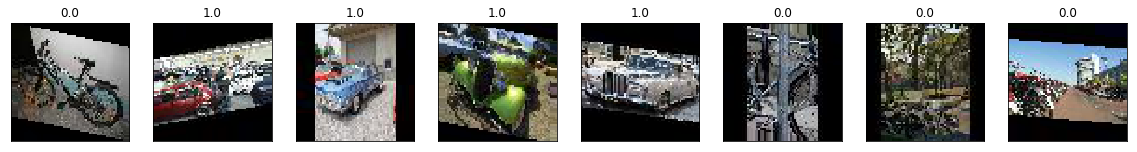

In [14]:
# TODO
plt.figure(figsize=(20,20))
nplot = 8
X, y = train_generator.next()
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    plt.title(y[i])
    disp_image(X[i])

## Train the Model

Compile the model.  Select the correct `loss` function, `optimizer` and `metrics`.  Remember that we are performing binary classification.

In [15]:
# TODO.
# model.compile(...)
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

When using an `ImageDataGenerator`, we have to set two parameters manually:
* `steps_per_epoch =  training data size // batch_size`
* `validation_steps =  test data size // batch_size`

We can obtain get the training and test data size from `train_generator.n` and `test_generator.n`, respectively.

In [16]:
# TODO
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

Now, we run the fit.  If you are using a CPU on a regular laptop, each epoch will take about 3-4 minutes, so you should be able to finish 5 epochs or so within 20 minutes.  On a reasonable GPU, even with the larger images, it will take about 10 seconds per epoch.
* If you use `(nrow,ncol) = (64,64)` images, you should get around 90% accuracy after 5 epochs.
* If you use `(nrow,ncol) = (150,150)` images, you should get around 96% accuracy after 5 epochs.  But, this will need a GPU.

You will get full credit for either version.  With more epochs, you may get slightly higher, but you will have to play with the damping.

In [17]:
nepochs = 5  # Number of epochs

# Call the fit function
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
62/62 [==============================] - 296s - loss: 0.5418 - acc: 0.7495 - val_loss: 0.3209 - val_acc: 0.8639
Epoch 2/5
62/62 [==============================] - 278s - loss: 0.3689 - acc: 0.8458 - val_loss: 0.2733 - val_acc: 0.8826
Epoch 3/5
62/62 [==============================] - 286s - loss: 0.3232 - acc: 0.8599 - val_loss: 0.2781 - val_acc: 0.8836
Epoch 4/5
62/62 [==============================] - 262s - loss: 0.3094 - acc: 0.8760 - val_loss: 0.2251 - val_acc: 0.9157
Epoch 5/5
62/62 [==============================] - 279s - loss: 0.2883 - acc: 0.8810 - val_loss: 0.2099 - val_acc: 0.9080


## Print Example Errors

This section is bonus, since it was not included in the original version of this lab.  

Find four examples in the test dataset where the classifier made a mistake and display those.  This is useful for debugging to see where the classifier is going wrong.  One way to find four examples, is to:
*  Generate a mini-batch `X,y` from the `test_generator.next()` method
*  Predict the labels using the `model.predict` and compute a predicted label `yhat`.
*  Find the locations `i` where `yhat[i] != y[i]`.
*  Keep going through mini-batches until you have four errors.
*  Print the four error images.

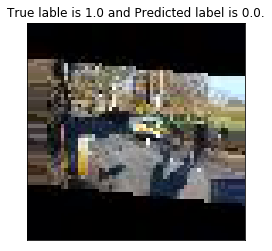

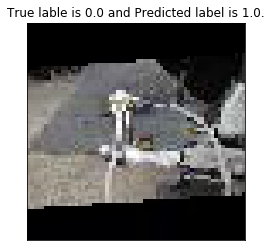

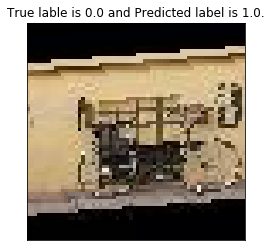

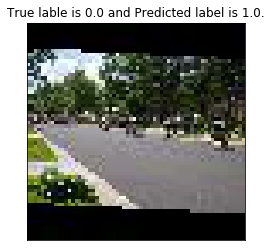

In [47]:
#TODO -- BONUS:  Find error images and print them
length = 0
yhat = np.zeros(32)
while True:
    X,y = test_generator.next()
    ypre = model.predict(X)
    for i, yp in enumerate(ypre):
        if (yp>0.5): yhat[i] = 1
        else: yhat[i] = 0
        if (y[i] != yhat[i]): 
            length += 1
            disp_image(X[i])
            plt.title("True lable is %.1f and Predicted label is %.1f." % (y[i], yhat[i]))
            plt.show()
            if (length == 4): break;
    if (length >= 4): break;